<a href="https://colab.research.google.com/github/kaphi10/Sail_work/blob/master/MnistGAN_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#CHECK FOR GPU PRESENCE



In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:

import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices("GPU"))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured with memory growth")
else:
    print("No GPU detected")

GPU configured with memory growth


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

### To Do
- import the load the data using tensorflow dataset
-preprocessed the data


In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(Xtrain,ytrain),(_,_)=mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
Xtrain.shape

(60000, 28, 28)

In [5]:
def display_sample(num):
    #Print this sample's label
    label = ytrain[num]

    #Reshape the 784 values to a 28x28 image
    image = Xtrain[num].reshape([28,28])
    plt.title(f'Sample: {num}  Label: {label}')
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

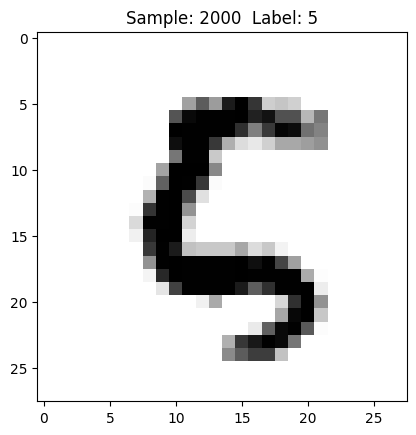

In [6]:
display_sample(2000)

### Nomarlize the data
Convert the shape to float to allow neural network train the model
i.e xtrain.shape[0] is the length of the (Mnist dataset)
x_train=(Xtrain-127.5)/127.5

Note:
The pixex value are originally stored as integer (0-255), GANs work better in the range [-1, 1] instead of [0, 255]



In [7]:
Xtrain=Xtrain.reshape(Xtrain.shape[0],28,28,1).astype('float32')
Xtrain=(Xtrain-127.5)/127.5

In [8]:
Xtrain.shape

(60000, 28, 28, 1)

In [9]:
Buffer_size=60000
Batch_size=256

In [10]:
#Xtrain

In [11]:
#Create the training dataset from tensorflow
train_data=tf.data.Dataset.from_tensor_slices(Xtrain).shuffle(Buffer_size).batch(Batch_size)

In [12]:

LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

In [13]:
#build generator
def build_generator():
  model=keras.Sequential([
    layers.Dense(7*7*256,input_shape=(LATENT_DIM,),use_bias=False, kernel_initializer=WEIGHT_UNIT),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Reshape((7,7,256)),

    layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(128,(5,5),strides=(2,2),padding='same',use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(1,(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
  ])
  return model
generator=build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
#build descriminator
def build_discriminator():
    model=keras.Sequential([

    layers.Conv2D(64,(5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.3),
        layers.Flatten(),

    layers.Dense(1, activation='sigmoid')
      ])
    return model
discriminator=build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
cross_entropy=keras.losses.BinaryCrossentropy()

In [16]:
#create discriminator loss
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

In [17]:
#create generator loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [18]:
generator_optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)

In [19]:
#build subclass model
class GAN(keras.Model):
  def __init__(self,discriminator,generator,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.discriminator=discriminator
    self.generator=generator
  def compile(self,discriminator_optimizer,generator_optimizer,d_loss,g_loss):
    super(GAN, self).compile()
    self.discriminator_optimizer=discriminator_optimizer
    self.generator_optimizer=generator_optimizer
    self.d_loss=d_loss
    self.g_loss=g_loss
  def train_step(self, real_image):
    batch_size=tf.shape(real_image)[0]

    #Train descriminator
    noise=tf.random.normal([batch_size,LATENT_DIM])
    with tf.GradientTape() as d_tape:
      generated_image=self.generator(noise)
      real_output=self.discriminator(real_image)
      fake_output=self.discriminator(generated_image)
      d_loss=self.d_loss(real_output,fake_output)

    d_gradient=d_tape.gradient(d_loss,self.discriminator.trainable_variables)
    self.discriminator_optimizer.apply_gradients(zip(d_gradient,self.discriminator.trainable_variables))

     # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradient = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.generator_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}



In [20]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.seed = tf.random.normal([num_images, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5 #rescaleto range [0, 233]

      plt.figure(figsize=(10,10))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
      plt.show()

In [21]:
Epoch=100

In [22]:
gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)


Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - d_loss: 1.0599 - g_loss: 0.9864

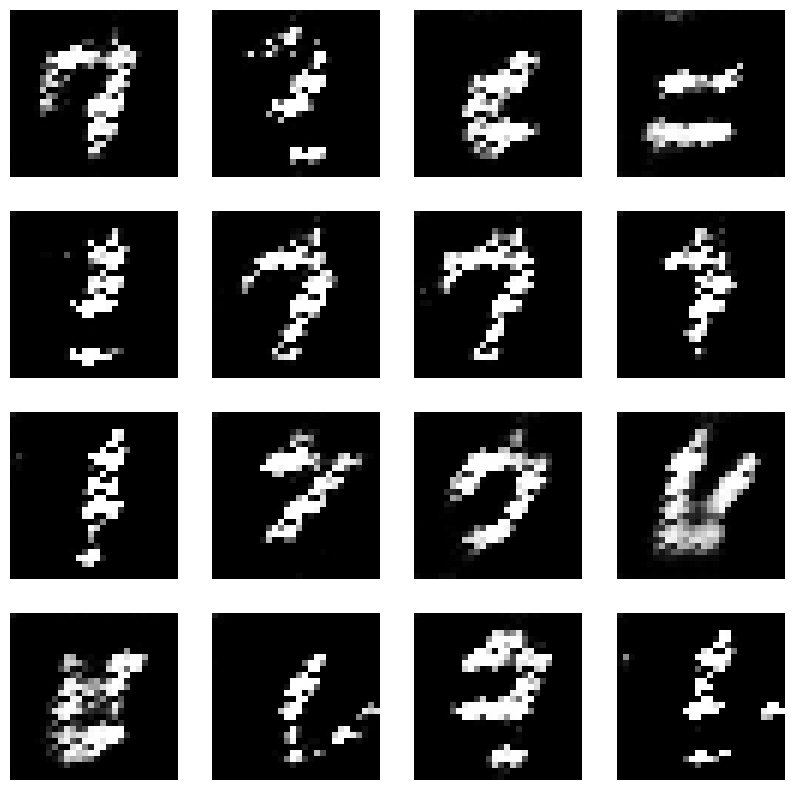

235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - d_loss: 1.0597 - g_loss: 0.9874
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - d_loss: 1.1931 - g_loss: 0.9689
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - d_loss: 1.2427 - g_loss: 0.9399
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - d_loss: 1.2670 - g_loss: 0.8870
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.2985 - g_loss: 0.8454
Epoch 6/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3035 - g_loss: 0.8141

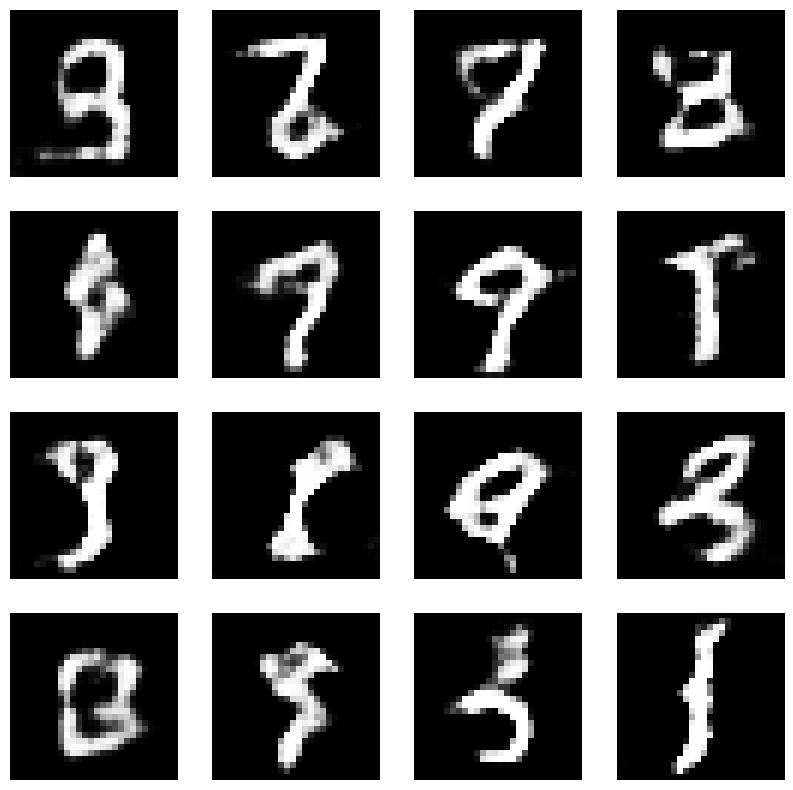

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - d_loss: 1.3028 - g_loss: 0.8150
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - d_loss: 1.3021 - g_loss: 0.8088
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.2984 - g_loss: 0.8171
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.2849 - g_loss: 0.8093
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.2871 - g_loss: 0.8483
Epoch 11/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.2709 - g_loss: 0.8087

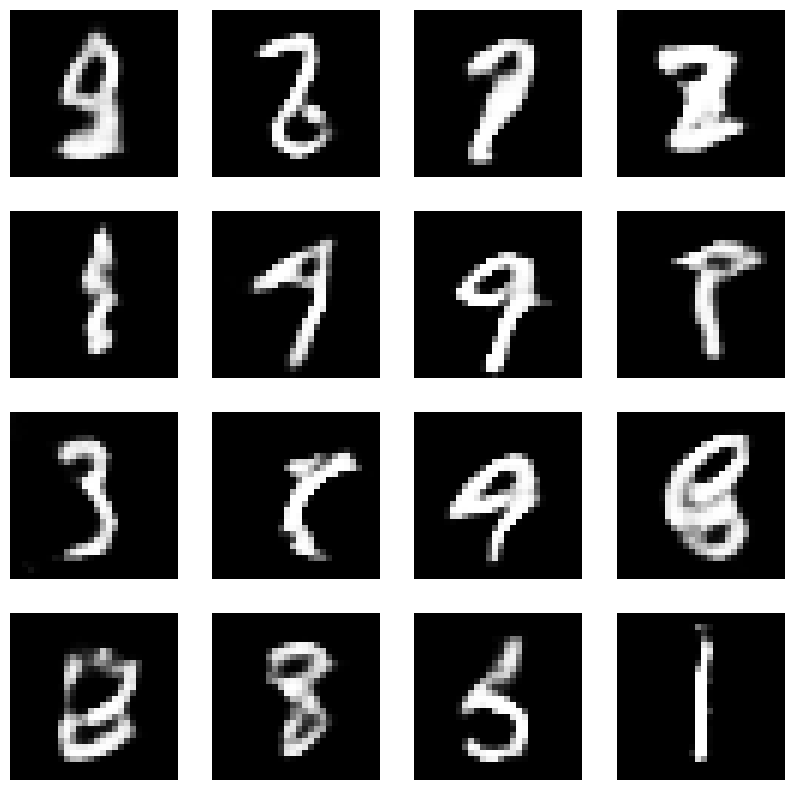

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.2707 - g_loss: 0.8088
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.2750 - g_loss: 0.8427
Epoch 13/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.2677 - g_loss: 0.8240
Epoch 14/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.2842 - g_loss: 0.8560
Epoch 15/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.2717 - g_loss: 0.8675
Epoch 16/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.2669 - g_loss: 0.8237

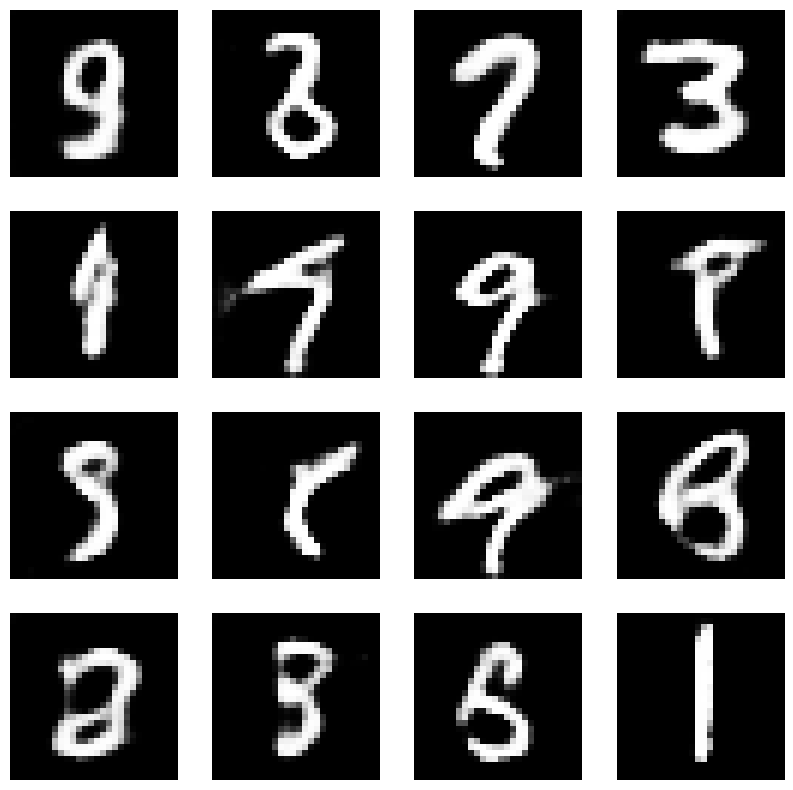

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.2675 - g_loss: 0.8229
Epoch 17/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.2718 - g_loss: 0.8462
Epoch 18/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - d_loss: 1.2752 - g_loss: 0.8174
Epoch 19/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - d_loss: 1.2815 - g_loss: 0.8207
Epoch 20/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.2937 - g_loss: 0.8404
Epoch 21/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.2900 - g_loss: 0.8041

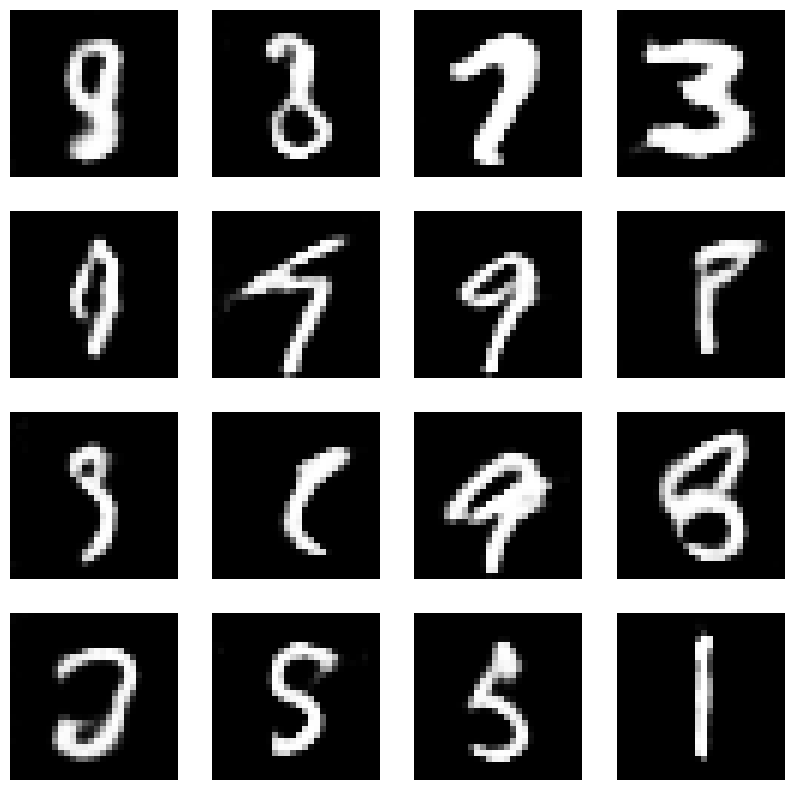

235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.2897 - g_loss: 0.8038
Epoch 22/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3006 - g_loss: 0.8293
Epoch 23/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3015 - g_loss: 0.8231
Epoch 24/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3041 - g_loss: 0.7970
Epoch 25/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - d_loss: 1.3295 - g_loss: 0.8866
Epoch 26/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3004 - g_loss: 0.8103

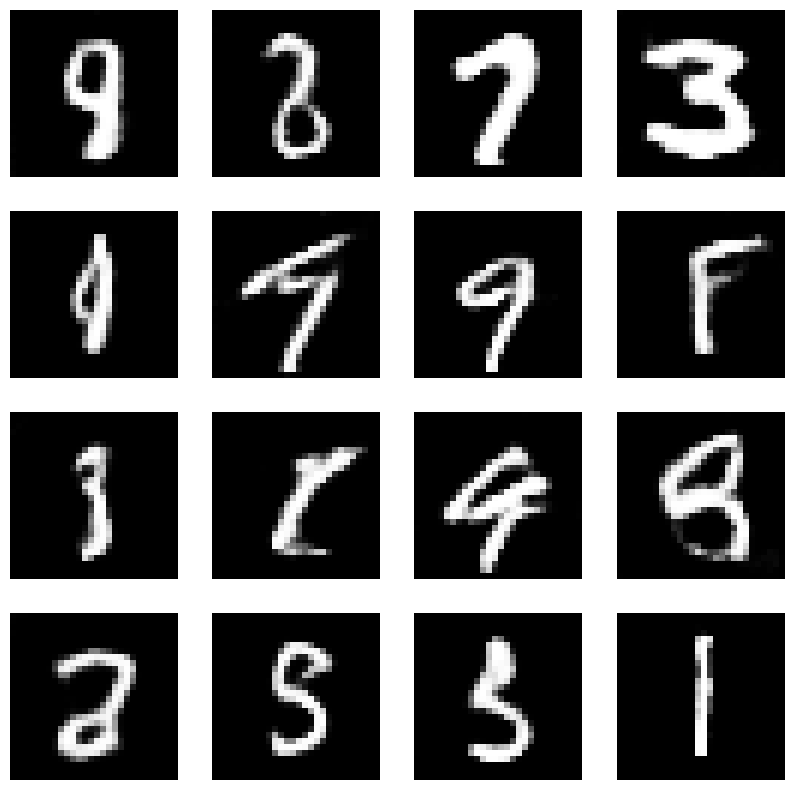

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - d_loss: 1.3006 - g_loss: 0.8093
Epoch 27/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3089 - g_loss: 0.7831
Epoch 28/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - d_loss: 1.3116 - g_loss: 0.7883
Epoch 29/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - d_loss: 1.3160 - g_loss: 0.7953
Epoch 30/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3163 - g_loss: 0.7911
Epoch 31/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3181 - g_loss: 0.7905

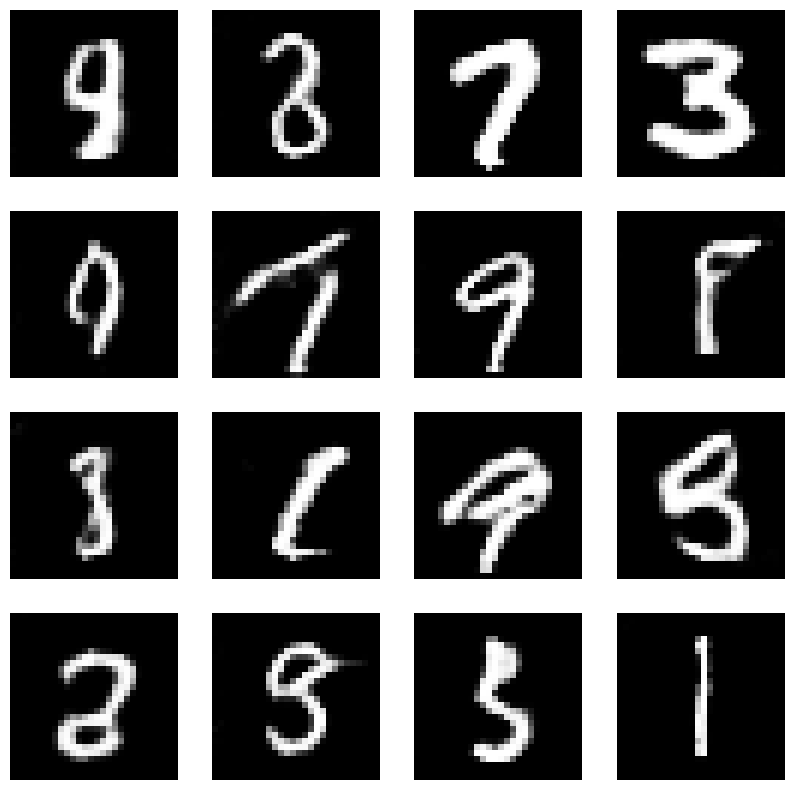

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - d_loss: 1.3188 - g_loss: 0.7892
Epoch 32/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - d_loss: 1.3401 - g_loss: 0.9049
Epoch 33/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3117 - g_loss: 0.7765
Epoch 34/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3152 - g_loss: 0.7777
Epoch 35/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3228 - g_loss: 0.7958
Epoch 36/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3165 - g_loss: 0.7945

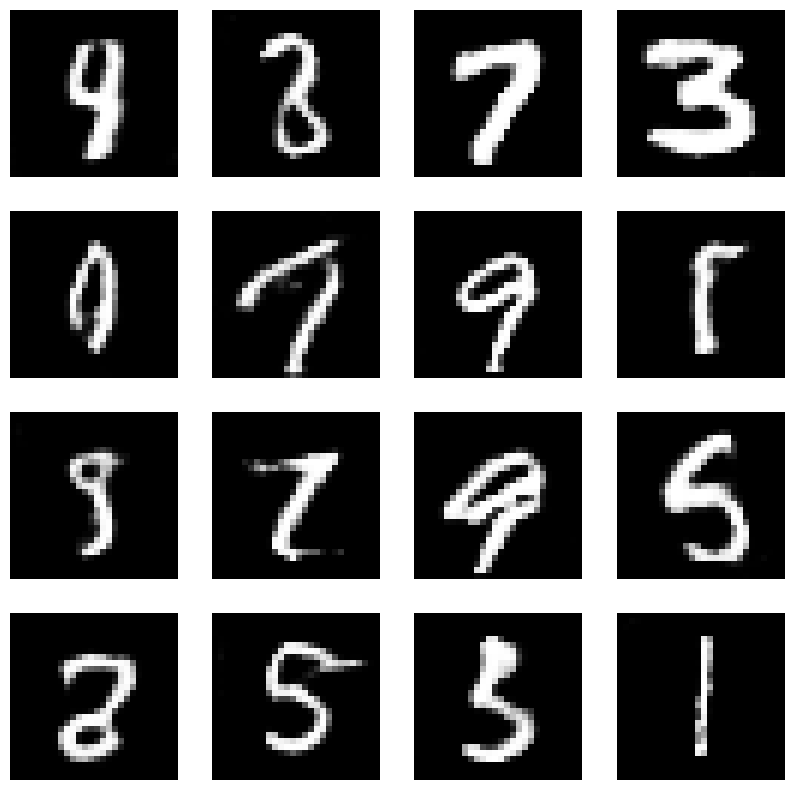

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - d_loss: 1.3168 - g_loss: 0.7929
Epoch 37/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3173 - g_loss: 0.7827
Epoch 38/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3189 - g_loss: 0.7815
Epoch 39/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3225 - g_loss: 0.7925
Epoch 40/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3214 - g_loss: 0.7921
Epoch 41/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3200 - g_loss: 0.7848

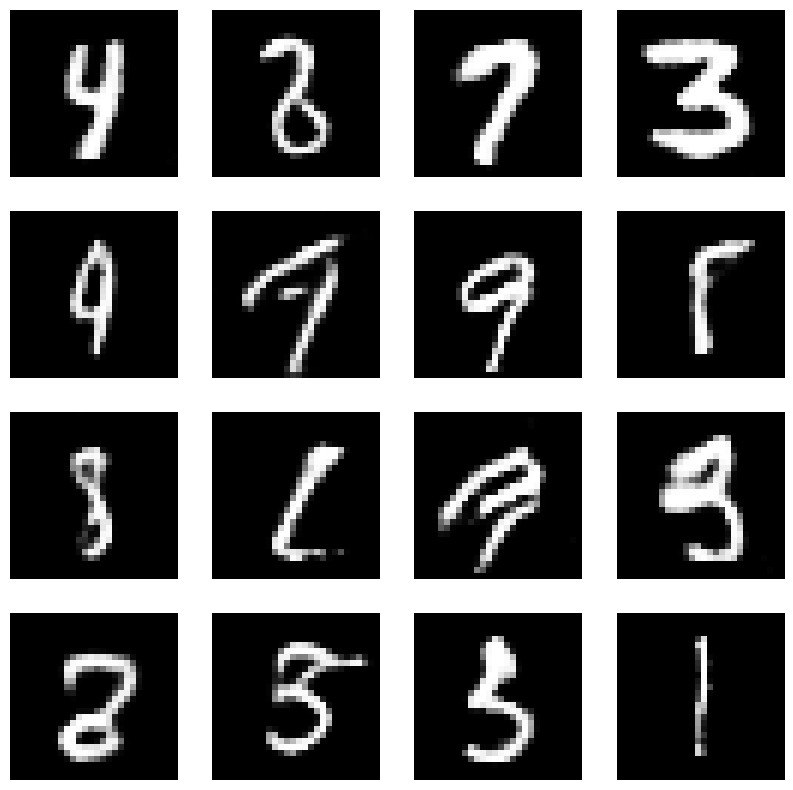

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3202 - g_loss: 0.7856
Epoch 42/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3218 - g_loss: 0.7902
Epoch 43/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - d_loss: 1.3197 - g_loss: 0.7879
Epoch 44/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - d_loss: 1.3217 - g_loss: 0.7873
Epoch 45/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3262 - g_loss: 0.8061
Epoch 46/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3204 - g_loss: 0.7818

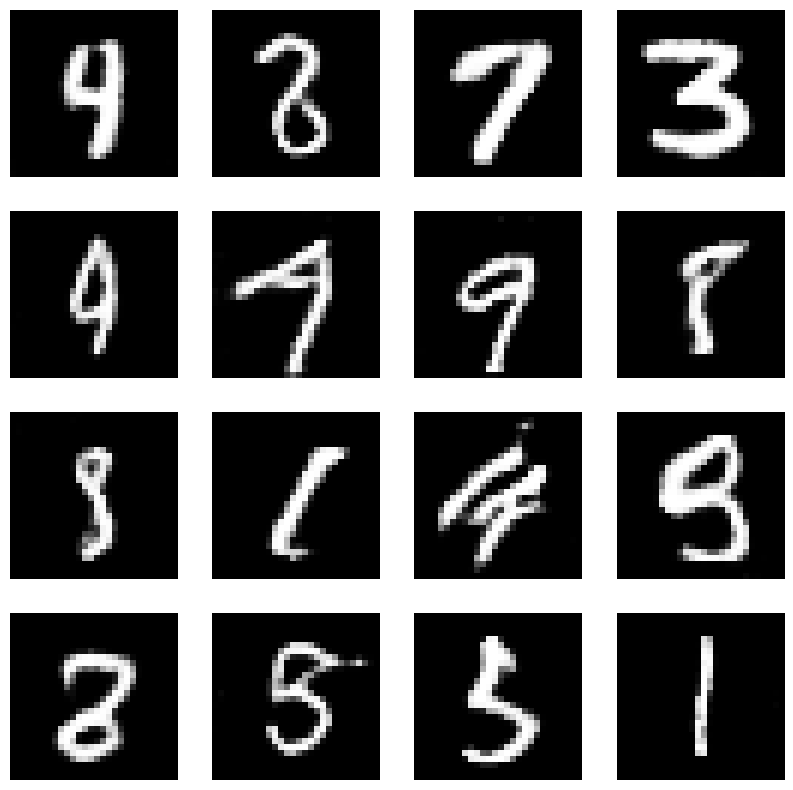

235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - d_loss: 1.3202 - g_loss: 0.7820
Epoch 47/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3224 - g_loss: 0.7962
Epoch 48/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3213 - g_loss: 0.7863
Epoch 49/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3221 - g_loss: 0.7900
Epoch 50/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3200 - g_loss: 0.7856
Epoch 51/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - d_loss: 1.3212 - g_loss: 0.7925

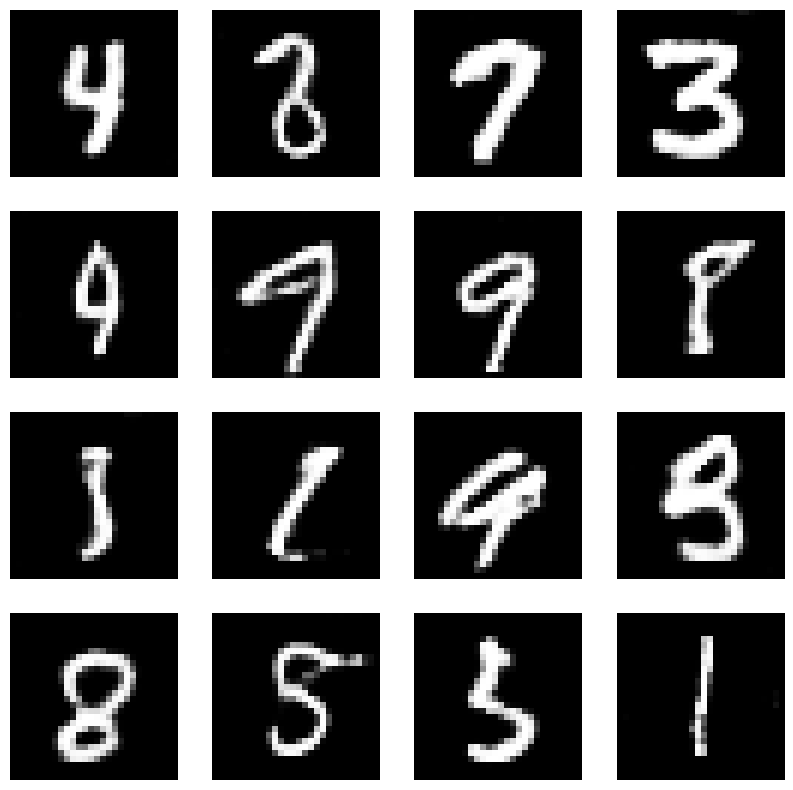

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3208 - g_loss: 0.7921
Epoch 52/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3194 - g_loss: 0.7885
Epoch 53/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3267 - g_loss: 0.8080
Epoch 54/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3196 - g_loss: 0.7811
Epoch 55/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3198 - g_loss: 0.7883
Epoch 56/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3198 - g_loss: 0.7856

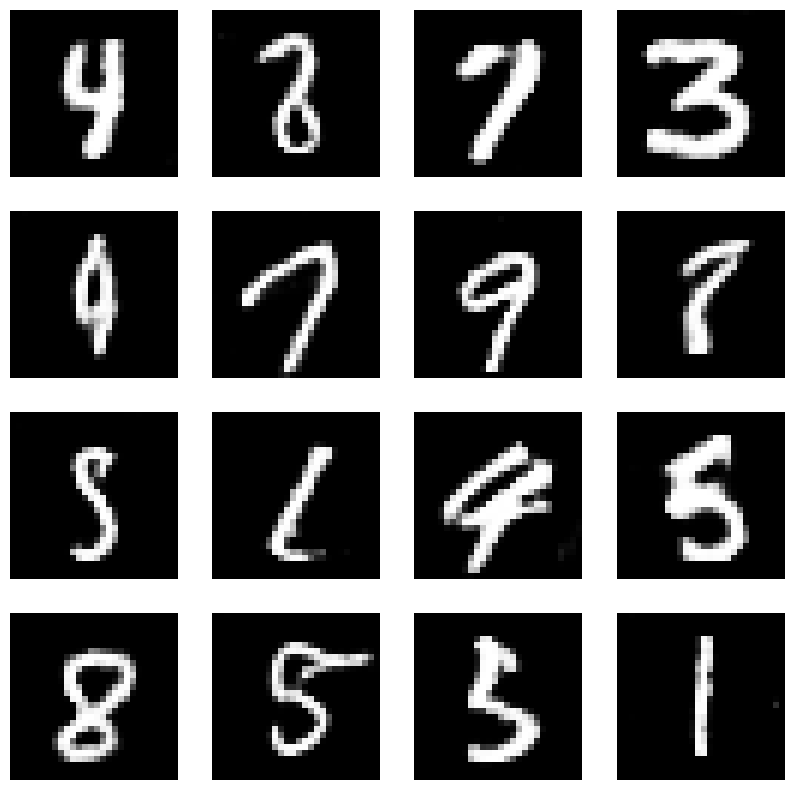

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3194 - g_loss: 0.7864
Epoch 57/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3332 - g_loss: 0.8835
Epoch 58/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3175 - g_loss: 0.7775
Epoch 59/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3203 - g_loss: 0.7829
Epoch 60/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3191 - g_loss: 0.7824
Epoch 61/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - d_loss: 1.3185 - g_loss: 0.7837

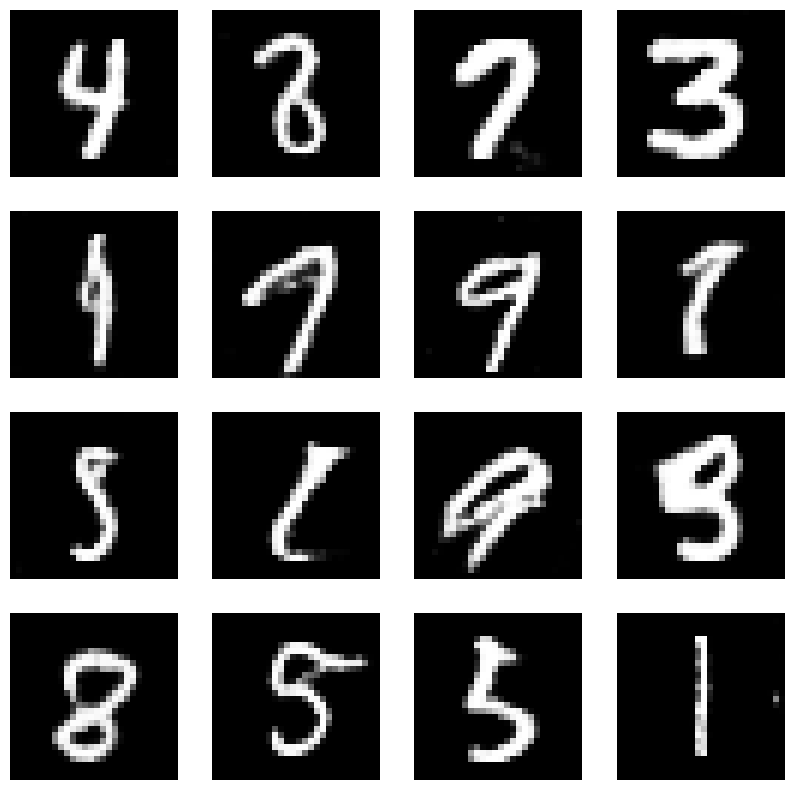

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - d_loss: 1.3183 - g_loss: 0.7839
Epoch 62/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - d_loss: 1.3186 - g_loss: 0.7823
Epoch 63/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3204 - g_loss: 0.7876
Epoch 64/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3204 - g_loss: 0.7904
Epoch 65/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3234 - g_loss: 0.7946
Epoch 66/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3194 - g_loss: 0.7898

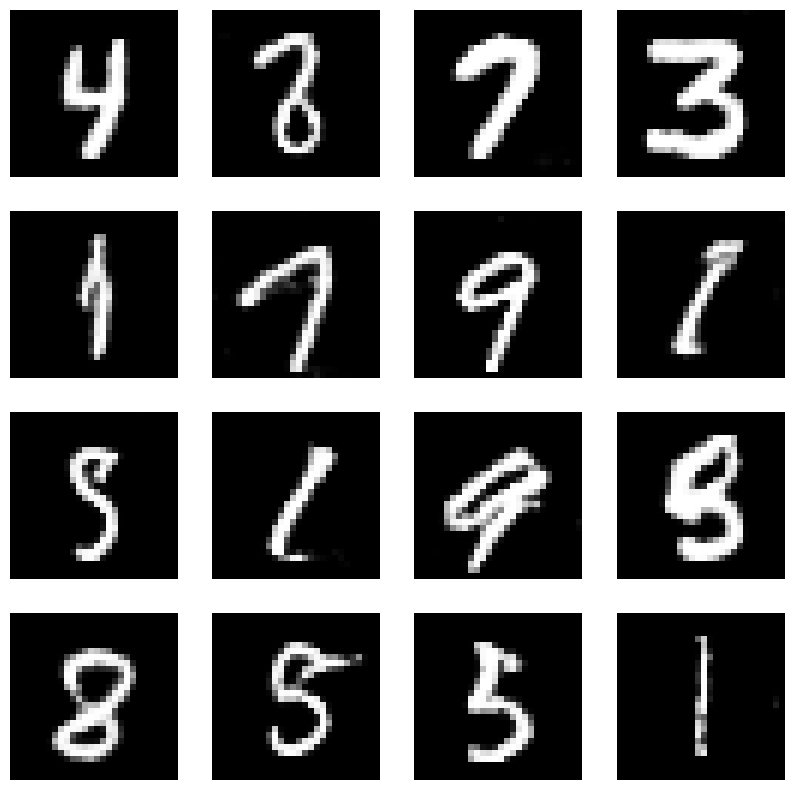

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3197 - g_loss: 0.7889
Epoch 67/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3197 - g_loss: 0.7900
Epoch 68/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3188 - g_loss: 0.7926
Epoch 69/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3215 - g_loss: 0.7857
Epoch 70/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3206 - g_loss: 0.7884
Epoch 71/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3167 - g_loss: 0.7832

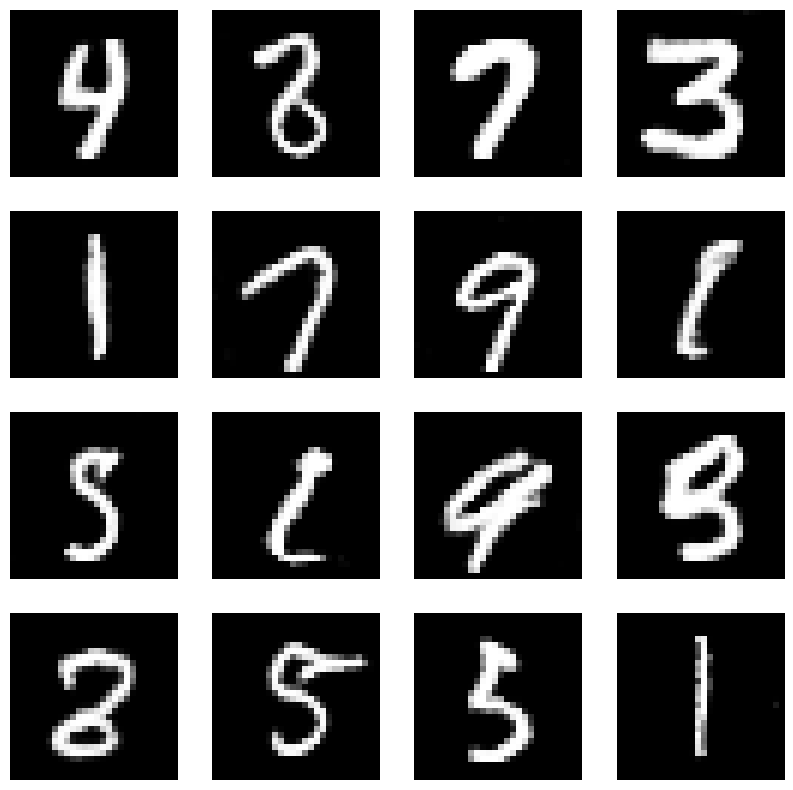

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - d_loss: 1.3162 - g_loss: 0.7842
Epoch 72/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - d_loss: 1.3180 - g_loss: 0.7922
Epoch 73/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3169 - g_loss: 0.7854
Epoch 74/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3176 - g_loss: 0.7843
Epoch 75/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3198 - g_loss: 0.7947
Epoch 76/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3180 - g_loss: 0.7959

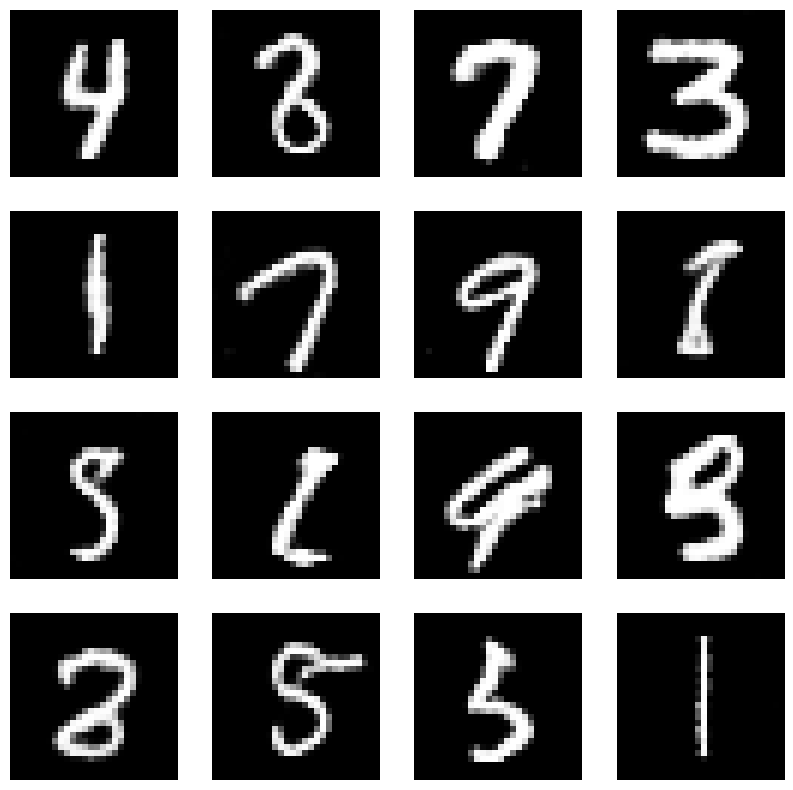

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3176 - g_loss: 0.7955
Epoch 77/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3186 - g_loss: 0.7958
Epoch 78/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3171 - g_loss: 0.7913
Epoch 79/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3160 - g_loss: 0.7897
Epoch 80/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3161 - g_loss: 0.7872
Epoch 81/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3183 - g_loss: 0.7947

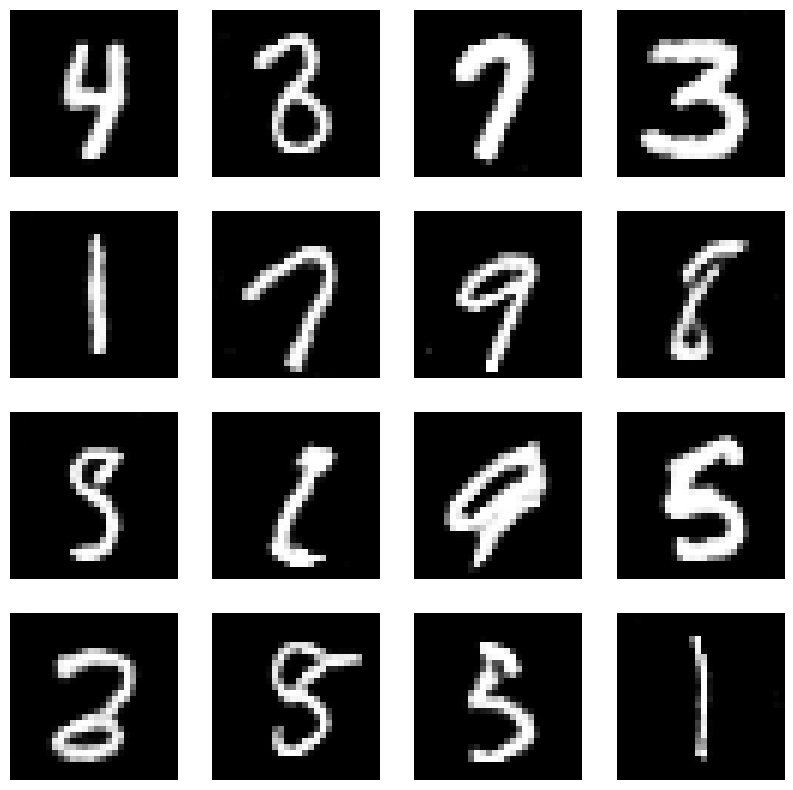

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3182 - g_loss: 0.7949
Epoch 82/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3138 - g_loss: 0.7891
Epoch 83/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3164 - g_loss: 0.7955
Epoch 84/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3161 - g_loss: 0.7929
Epoch 85/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3188 - g_loss: 0.7968
Epoch 86/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3145 - g_loss: 0.7898

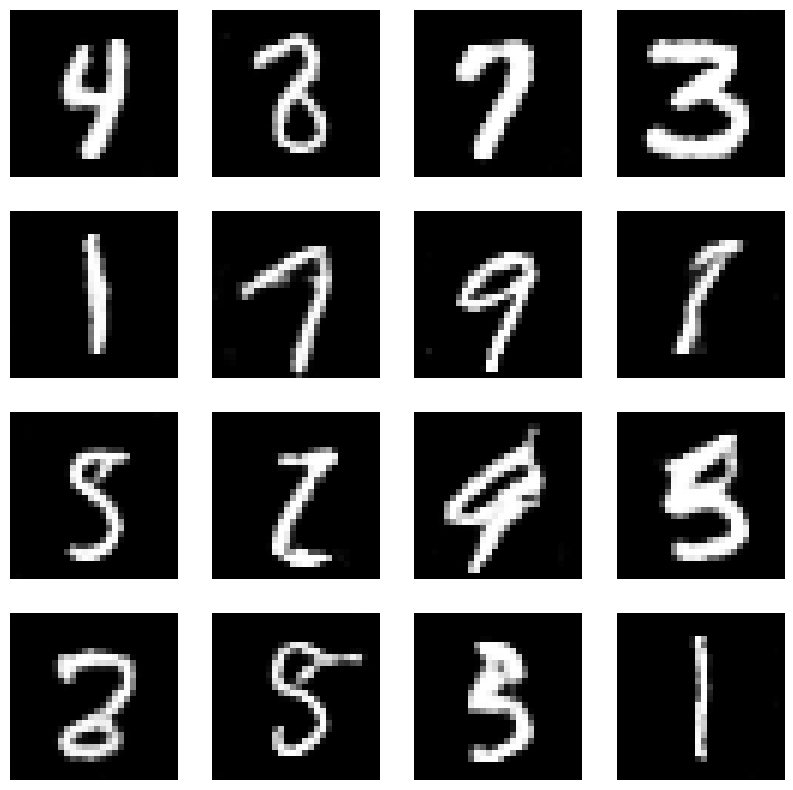

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3146 - g_loss: 0.7901
Epoch 87/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3148 - g_loss: 0.7934
Epoch 88/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3147 - g_loss: 0.7941
Epoch 89/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3159 - g_loss: 0.7958
Epoch 90/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3162 - g_loss: 0.7927
Epoch 91/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3125 - g_loss: 0.7943

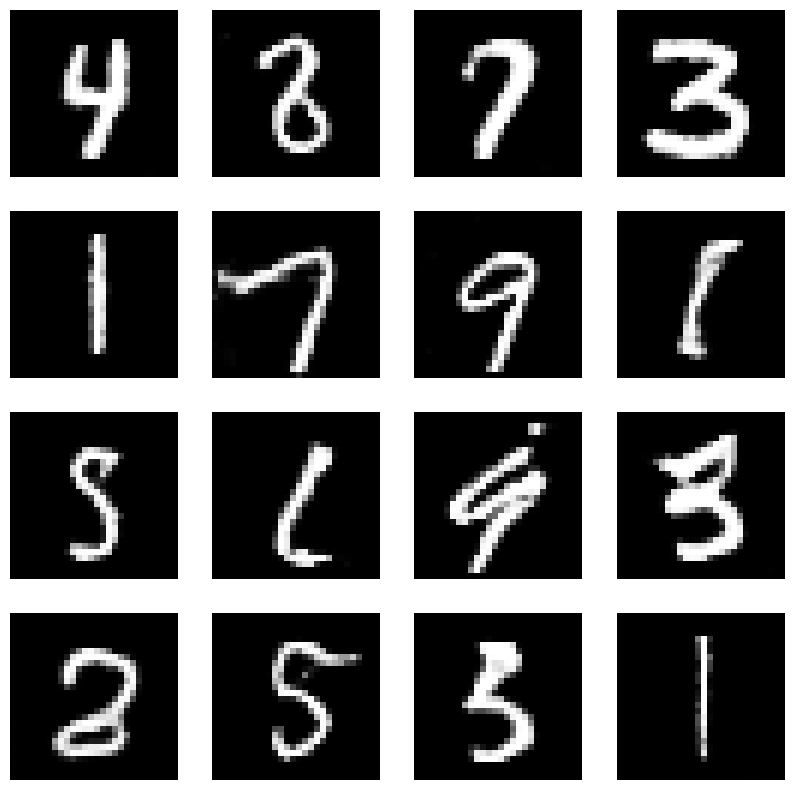

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - d_loss: 1.3126 - g_loss: 0.7939
Epoch 92/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - d_loss: 1.3147 - g_loss: 0.7992
Epoch 93/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - d_loss: 1.3133 - g_loss: 0.7938
Epoch 94/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3131 - g_loss: 0.7957
Epoch 95/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - d_loss: 1.3128 - g_loss: 0.7952
Epoch 96/100
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - d_loss: 1.3135 - g_loss: 0.7989

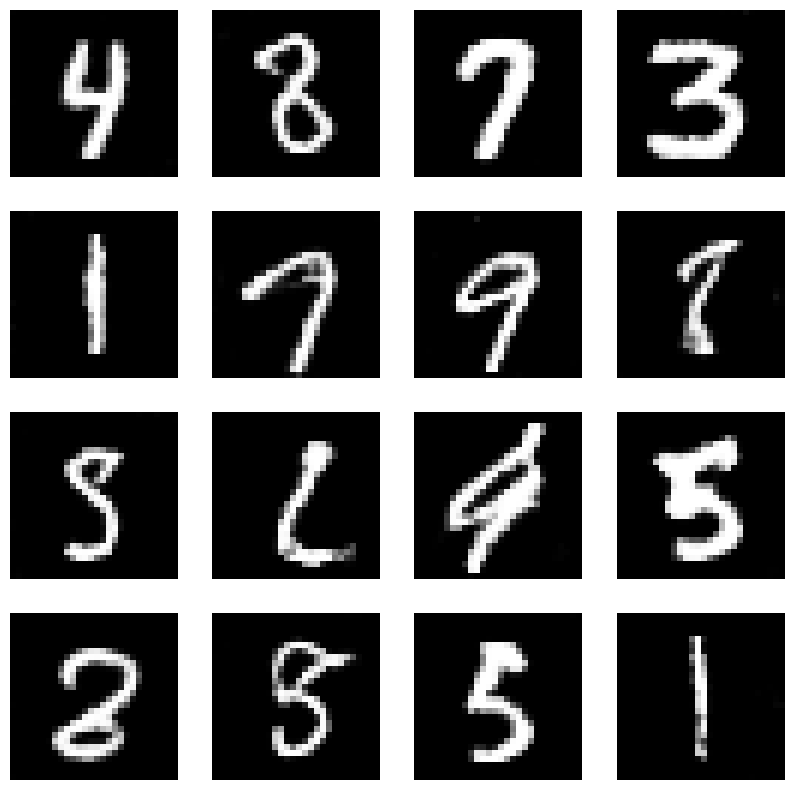

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - d_loss: 1.3136 - g_loss: 0.7997
Epoch 97/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3113 - g_loss: 0.7934
Epoch 98/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - d_loss: 1.3134 - g_loss: 0.7969
Epoch 99/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - d_loss: 1.3096 - g_loss: 0.7946
Epoch 100/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - d_loss: 1.3104 - g_loss: 0.7991


In [23]:
history = gan.fit(train_data, epochs=Epoch, callbacks=[ImageCallback()])

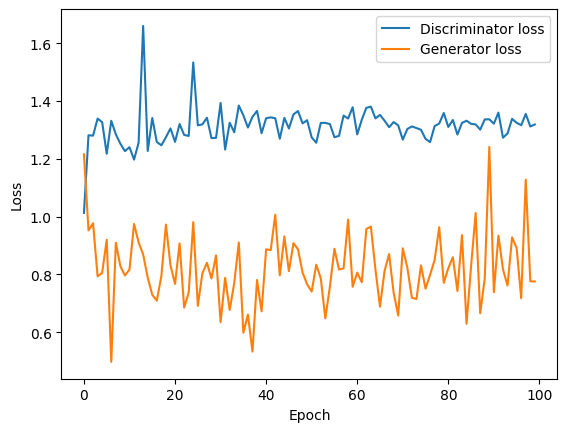

In [24]:

plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5 # denormalize

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

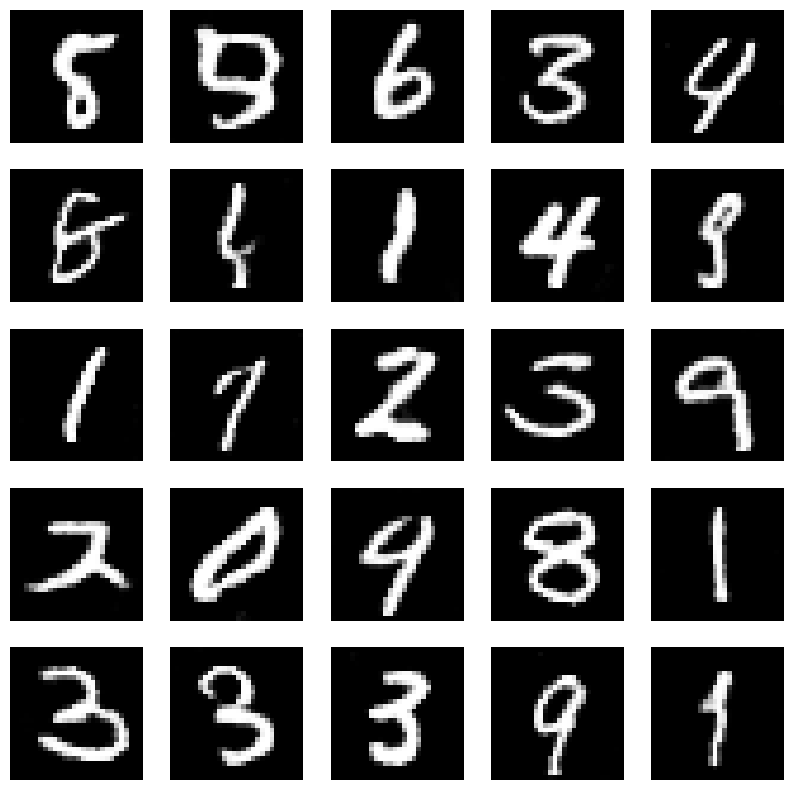

In [28]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
plt

In [29]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
#generator.save("/content/drive/My Drive/mnist_gan_generator.h5")

In [31]:
generator.save("/content/drive/My Drive/mnist_gan_generator.keras")